# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off Speed RHP](#Off-Speed-RHP)
    - [Off Speed LHP](#Off-Speed-LHP)

# Imports

In [75]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [76]:
data = pd.read_csv('../data/model-pitches-rv2022.csv', index_col = [0])
tu = pd.read_csv('../data/season23.csv')
tu = tu.loc[tu['PitcherTeam'] == 'TUS_PIO']
pd.set_option('max_columns', None)
#data.dropna(inplace = True)
print(data.shape)
data.head()

(682572, 65)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_rel_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_rel_outs_scale,woba,wraa_change,rv
0,"Zastryzny, Rob",L,FF,93.5,2451.0,167.0,-3.36,17.40,26.213904,94.6,-1.70,5.95,6.6,53.88,0.76,3.38,S,2,2,2-2,L,NaN,strike,field_out,NaN,NaN,NaN,0.0,1.0,NaN,78.0,6.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,1,1,0.0,0.0,0.0,0.11,-0.11,0.00,-0.11,-0.27,0.001,1.209,-0.326,0.001,0.269,-0.184,-0.110
1,"Zastryzny, Rob",L,CU,80.9,2266.0,273.0,13.44,-0.96,28.009889,81.1,-2.06,5.59,6.5,53.95,0.66,0.49,B,1,2,1-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,5.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,CU,35.2,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,0.032,0.032
2,"Zastryzny, Rob",L,FF,92.3,2321.0,157.0,-3.36,18.96,25.146262,92.8,-1.65,5.93,6.7,53.84,0.20,3.12,S,1,2,1-2,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,4.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,-0.152,-0.152
3,"Zastryzny, Rob",L,FF,94.3,2391.0,159.0,-4.80,17.28,25.355249,94.4,-1.65,5.93,6.4,54.09,-0.53,3.69,B,0,2,0-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,3.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.197,0.017,0.017
4,"Zastryzny, Rob",L,FF,93.4,2446.0,156.0,-3.60,18.00,26.188437,93.3,-1.81,5.93,6.4,54.13,0.62,2.19,S,0,1,0-1,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,2.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.265,-0.047,-0.047


In [77]:
print(tu.shape)
tu.head()

(4627, 227)


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,Notes,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,HitType,PitchUUID,yt_RelSpeed,yt_RelHeight,yt_RelSide,yt_VertRelAngle,yt_HorzRelAngle,yt_ZoneSpeed,yt_PlateLocHeight,yt_PlateLocSide,yt_VertApprAngle,yt_HorzApprAngle,yt_ZoneTime,yt_HorzBreak,yt_InducedVertBreak,yt_OutOfPlane,yt_FSRI,yt_EffectiveSpin,yt_GyroSpin,yt_Efficiency,yt_SpinComponentX,yt_SpinComponentY,yt_SpinComponentZ,yt_HitVelocityX,yt_HitVelocityY,yt_HitVelocityZ,yt_HitLocationX,yt_HitLocationY,yt_HitLocationZ,yt_GroundLocationX,yt_GroundLocationY,yt_HitBreakX,yt_HitBreakY,yt_HitBreakT,yt_HitSpinComponentX,yt_HitSpinComponentY,yt_HitSpinComponentZ,yt_SessionName,Note,yt_PitchSpinConfidence,yt_PitchReleaseConfidence,yt_HitSpinConfidence,yt_EffectiveBattingSpeed,yt_ReleaseAccuracy,yt_ZoneAccuracy,yt_SeamLat,yt_SeamLong,yt_ReleaseDistance,No.,%_BallCalled,%_BallIntentional,%_BallinDirt,%_Foul,%_FoulBall,%_FoulTip,%_HitByPitch,%_InPlay,%_StrikeCalled,%_StrikeSwinging,%_Strike,hard_hit_summary
0,1,4/21/2023,59:19.2,1,1,"Salyards, Brady",1000238765.0,Right,TUS_PIO,"LeGrand, JC",NaN,Undefined,AND_UNI,Undefined,1,Top,0,0,0,Fastball,Sinker,Undefined,Undefined,Undefined,0.0,0.0,NaN,87.3,-2.3,-2.8,2342.2,234.9,1:45,5.8,2.3,6.3,-23.1,12.7,16.7,1.7,1.1,80.8,-6.6,0.2,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,7.5,-2.1,50.0,5.6,5.5,-126.8,-5.7,-15.4,23.3,-19.8,TUS_PIO,AND_UNI,PioneerPark,D2,AL,20230421-PioneerPark-1,c4810b90-e08f-11ed-ae10-81d380c79465,87.5,NaN,NaN,6.5,NaN,NaN,NaN,NaN,NaN,NaN,3361f79d-8373-4b2c-94d7-6dde80d14358,4/21/2023,59:19.2,2023-04-21T17:59:19.2200000-04:00,2023-04-21T21:59:19.2200000Z,NaN,v3,471724.0,BPT-3377,NaN,"McCauley, Blaze",1000051440.0,Right,TUS_PIO,6b741ab8-f04f-4bf2-a6ae-17d16aff774f,54.2,-127.6,11.6,5.8,-5.1,-9.9,-2.3,6.0,-7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [78]:
tu.TaggedPitchType.value_counts()

Fastball            2341
ChangeUp             635
Slider               613
Curveball            425
Splitter             225
FourSeamFastBall     221
Cutter                97
TwoSeamFastBall       65
Other                  3
Knuckleball            1
Undefined              1
Name: TaggedPitchType, dtype: int64

# Features

**Independent Variables:** Velocity, HB, IVB, Spin Axis, Release Side, Release Height, Release Extension

**Dependent Variable:** Run Value

### Multicolinearity - VIF

In [79]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'spin_axis', 'release_pos_x', 'release_pos_z', 'release_extension', 'rv']]

features_tu = tu[['Pitcher', 'PitcherThrows', 'TaggedPitchType', 'RelSpeed', 'HorzBreak', 'InducedVertBreak', 
                 'SpinAxis', 'RelSide', 'RelHeight', 'Extension']]

#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

In [80]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

In [81]:
fb_tu = features_tu[features_tu['TaggedPitchType'].isin(['Fastball', 'FourSeamFastBall', 'TwoSeamFastBall'])]
bb_tu = features_tu[features_tu['TaggedPitchType'].isin(['Slider', 'Cutter', 'Curveball'])]
os_tu = features_tu[features_tu['TaggedPitchType'].isin(['ChangeUp', 'Splitter'])]
rhp_tu = features_tu.loc[features_tu['PitcherThrows'] == 'Right']
lhp_tu = features_tu.loc[features_tu['PitcherThrows'] == 'Left']
rhp_fb_tu = fb_tu.loc[fb_tu['PitcherThrows'] == 'Right']
lhp_fb_tu = fb_tu.loc[fb_tu['PitcherThrows'] == 'Left']
rhp_bb_tu = bb_tu.loc[bb_tu['PitcherThrows'] == 'Right']
lhp_bb_tu = bb_tu.loc[bb_tu['PitcherThrows'] == 'Left']
rhp_os_tu = os_tu.loc[os_tu['PitcherThrows'] == 'Right']
lhp_os_tu = os_tu.loc[os_tu['PitcherThrows'] == 'Left']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [82]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fb.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.01


In [83]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['rv'])
y = features_fb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_fb_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.254
Test MAE: 0.131
Cross Val Score: [0.000454   0.00049482 0.00088722 0.00126165 0.00085941]
Cross Val Score: 0.001 

R2 Score: 0.001
RMSE: 0.255
MAE: 0.131


- Average RHP FB Run Value prediction error is .26 runs

In [84]:
rhp_fb_tu.dropna(inplace = True)

features_rhp_fb_tu = rhp_fb_tu.select_dtypes([np.number])
pred_rhp_fb_tu = lr.predict(features_rhp_fb_tu)
rhp_fb_tu['RV'] = pred_rhp_fb_tu

print(rhp_fb_tu.shape)
rhp_fb_tu.describe()

(2450, 11)


,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,RV
count,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000
mean,85.848735,9.782735,16.550490,212.400735,1.535592,5.958122,6.219306,0.009148
std,1.824810,4.376516,4.323906,17.114734,0.802664,0.396310,0.510677,0.006979
min,77.600000,-4.100000,-2.300000,19.700000,-0.100000,4.900000,4.900000,-0.010633
25%,84.800000,6.700000,13.500000,201.700000,0.900000,5.700000,5.800000,0.004356
50%,86.100000,10.100000,17.100000,212.000000,1.500000,5.900000,6.400000,0.008592
75%,87.200000,13.075000,19.900000,222.975000,1.975000,6.300000,6.600000,0.013092
max,90.600000,21.900000,26.700000,351.600000,3.800000,6.800000,7.300000,0.035816


### RHP Fastball Actual & Predicted Values

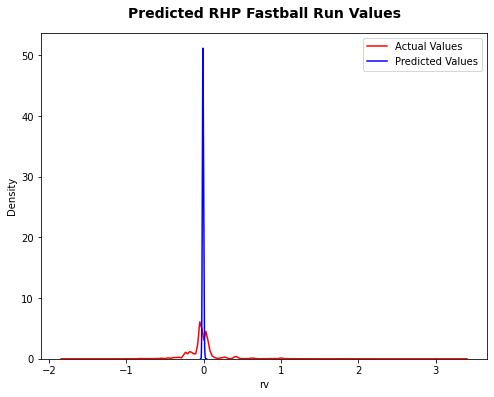

In [85]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Release Extension

In [86]:
rhp_fb_tu['n_pitches'] = 1
rhp_fb_tu['xRV'] = pred_rhp_fb_tu
rhp_fb_tu['RV/100'] = round(((rhp_fb_tu['RV'] / (rhp_fb_tu['n_pitches'])) * 100), 2)
rhp_fb_tu['xRV/100'] = round(((rhp_fb_tu['xRV'] / (rhp_fb_tu['n_pitches'])) * 100), 2)
rhp_fb_tu['Stuff+'] = 100 * (-rhp_fb_tu['xRV/100'] / -rhp_fb_tu['xRV/100'].mean())


grouped_fb_r = rhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                                    as_index = False)['n_pitches', 'RV', 'xRV',].sum()

avg_fb_r = rhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinAxis',
                                            'RelSide', 'RelHeight', 'Extension', 'Stuff+'].mean()
fb_r_rv_table = pd.merge(avg_fb_r, grouped_fb_r, how = 'left', on = ['Pitcher', 'PitcherThrows', 
                                                                     'TaggedPitchType'])

fb_r_rv_table['RV/100'] = round(((fb_r_rv_table['RV'] / (fb_r_rv_table['n_pitches'])) * 100), 2)
fb_r_rv_table['xRV/100'] = round(((fb_r_rv_table['xRV'] / (fb_r_rv_table['n_pitches'])) * 100), 2)

#Stuff+ = 100 * (predicted whiff% / league mean predicted whiff%)
#fb_r_rv_table['Stuff+'] = abs(100 * (fb_r_rv_table['xRV/100'] / fb_r_rv_table['xRV/100'].mean()))

fb_r_rv_table.insert(3, 'n_pitches', fb_r_rv_table.pop('n_pitches'))
fb_r_rv_table = fb_r_rv_table.round(1)
print(fb_r_rv_table.shape)
fb_r_rv_table.head(10)

(23, 16)


,Pitcher,PitcherThrows,TaggedPitchType,n_pitches,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,Stuff+,RV,xRV,RV/100,xRV/100
0,"Absher, Luke",Right,Fastball,412,85.6,9.9,16.8,212.4,1.5,5.8,6.6,86.2,3.2,3.2,0.8,0.8
1,"Absher, Luke",Right,FourSeamFastBall,28,85.6,7.7,17.5,205.3,1.5,5.7,6.7,65.1,0.2,0.2,0.6,0.6
2,"Absher, Luke",Right,TwoSeamFastBall,15,84.7,15.8,9.4,243.2,1.9,5.4,6.7,169.8,0.2,0.2,1.6,1.6
3,"Bonilla, Sam",Right,Fastball,45,87.3,7.8,15.7,208.1,2.1,5.8,6.5,50.1,0.2,0.2,0.5,0.5
4,"Bonilla, Sam",Right,FourSeamFastBall,31,86.6,3.7,14.3,194.6,1.9,5.8,6.8,59.3,0.2,0.2,0.5,0.5
5,"Bonilla, Sam",Right,TwoSeamFastBall,4,88.0,12.4,10.4,233.6,3.2,5.5,6.0,74.9,0.0,0.0,0.7,0.7
6,"Fox Birdwell, Trejen",Right,Fastball,265,87.0,9.6,13.0,219.1,3.1,5.8,5.8,87.1,2.1,2.1,0.8,0.8
7,"Fox Birdwell, Trejen",Right,TwoSeamFastBall,8,87.5,10.4,12.2,224.3,3.4,5.6,5.9,67.5,0.0,0.0,0.6,0.6
8,"Nelson, Jonathan",Right,Fastball,136,85.2,13.0,15.9,221.1,0.8,5.2,6.1,79.6,1.0,1.0,0.7,0.7
9,"Nelson, Jonathan",Right,FourSeamFastBall,20,84.7,10.0,16.7,212.7,1.0,5.3,6.1,75.9,0.1,0.1,0.7,0.7


### RHP Fastball xRV by HB & VB

RHP Fastball Avg Stuff+: 100.0


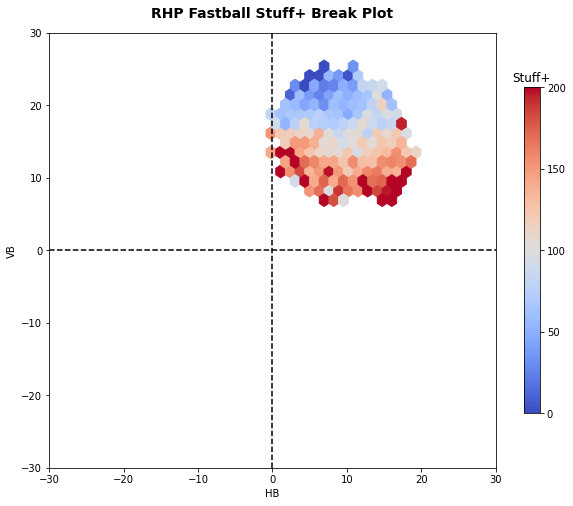

In [88]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_fb_tu['HorzBreak'], rhp_fb_tu['InducedVertBreak'], C = rhp_fb_tu['Stuff+'], cmap = 'coolwarm', 
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Stuff+ Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg Stuff+:', round(rhp_fb_tu['Stuff+'].mean(), 2))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [89]:
print('Baseline LHP Fastball RunValue Accuracy Score:', round(lhp_fb.rv.mean(), 2))

Baseline LHP Fastball RunValue Accuracy Score: -0.01


In [90]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['rv'])
y = features_fb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_fb_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.254
Test MAE: 0.13
Cross Val Score: [ 0.00077632  0.00034423 -0.00095937  0.00014251  0.00071534]
Cross Val Score: 0.0 

R2 Score: 0.001
RMSE: 0.253
MAE: 0.13


- Average LHP FB Run Value prediction error is .26 runs

In [91]:
lhp_fb_tu.dropna(inplace = True)

features_lhp_fb_tu = lhp_fb_tu.select_dtypes([np.number])
pred_lhp_fb_tu = lr.predict(features_lhp_fb_tu)
lhp_fb_tu['RV'] = pred_lhp_fb_tu

print(lhp_fb_tu.shape)
lhp_fb_tu.describe()

(170, 11)


,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,RV
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,80.852353,-10.072353,13.140000,138.382353,-1.230000,5.573529,5.537647,0.028812
std,1.600858,3.665576,4.750527,15.365882,0.254858,0.152899,0.175733,0.006438
min,76.000000,-19.300000,4.200000,104.400000,-1.700000,5.200000,5.000000,0.009215
25%,79.800000,-12.550000,9.250000,127.800000,-1.400000,5.500000,5.500000,0.024540
50%,81.150000,-9.700000,12.300000,138.250000,-1.300000,5.600000,5.500000,0.028581
75%,82.000000,-7.450000,17.100000,149.150000,-1.100000,5.700000,5.675000,0.033251
max,84.600000,-2.700000,24.500000,170.900000,-0.500000,6.000000,6.000000,0.045079


### LHP Fastball Actual & Predicted Values

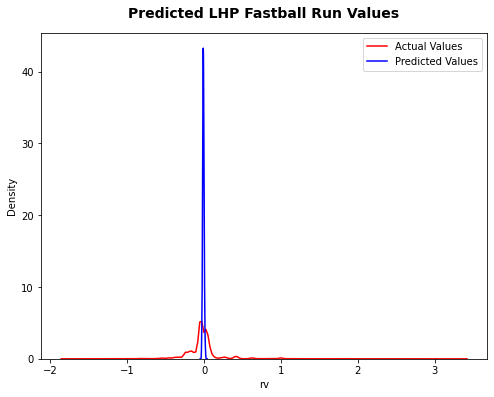

In [12]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [93]:
lhp_fb_tu['n_pitches'] = 1
lhp_fb_tu['xRV'] = pred_lhp_fb_tu
lhp_fb_tu['RV/100'] = round(((lhp_fb_tu['RV'] / (lhp_fb_tu['n_pitches'])) * 100), 2)
lhp_fb_tu['xRV/100'] = round(((lhp_fb_tu['xRV'] / (lhp_fb_tu['n_pitches'])) * 100), 2)
lhp_fb_tu['Stuff+'] = 100 * (-lhp_fb_tu['xRV/100'] / -lhp_fb_tu['xRV/100'].mean())


grouped_fb_l = lhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                                    as_index = False)['n_pitches', 'RV', 'xRV',].sum()

avg_fb_l = lhp_fb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinAxis',
                                            'RelSide', 'RelHeight', 'Extension', 'Stuff+'].mean()
fb_l_rv_table = pd.merge(avg_fb_l, grouped_fb_l, how = 'left', on = ['Pitcher', 'PitcherThrows', 
                                                                     'TaggedPitchType'])

fb_l_rv_table['RV/100'] = round(((fb_l_rv_table['RV'] / (fb_l_rv_table['n_pitches'])) * 100), 2)
fb_l_rv_table['xRV/100'] = round(((fb_l_rv_table['xRV'] / (fb_l_rv_table['n_pitches'])) * 100), 2)

#Stuff+ = 100 * (predicted whiff% / league mean predicted whiff%)
#fb_r_rv_table['Stuff+'] = abs(100 * (fb_r_rv_table['xRV/100'] / fb_r_rv_table['xRV/100'].mean()))

fb_l_rv_table.insert(3, 'n_pitches', fb_l_rv_table.pop('n_pitches'))
fb_l_rv_table = fb_l_rv_table.round(1)
print(fb_l_rv_table.shape)
fb_l_rv_table.head(10)

(2, 16)


,Pitcher,PitcherThrows,TaggedPitchType,n_pitches,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,Stuff+,RV,xRV,RV/100,xRV/100
0,"Crosby, Alex",Left,Fastball,125,81.1,-10.9,11.0,131.9,-1.2,5.5,5.5,106.2,3.8,3.8,3.1,3.1
1,"Martin, Scout",Left,Fastball,45,80.2,-7.7,19.2,156.3,-1.3,5.7,5.5,82.7,1.1,1.1,2.4,2.4


### LHP Fastball xRV by HB & VB

LHP Fastball Avg Stuff+: 100.0


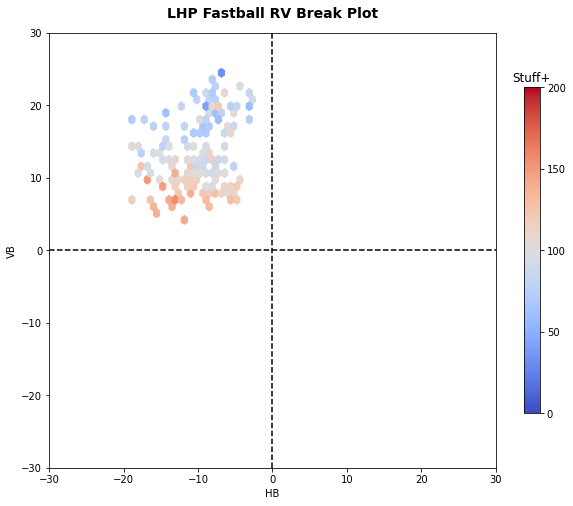

In [96]:
plt.figure(figsize = (10, 8))
plt.hexbin(lhp_fb_tu['HorzBreak'], lhp_fb_tu['InducedVertBreak'], C = lhp_fb_tu['Stuff+'], cmap = 'coolwarm',
           mincnt = 0, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg Stuff+:', round(lhp_fb_tu['Stuff+'].mean(), 2))

## Breaking Ball RHP

#### Slider, Cutter, Curveball, Knuckle Curve

In [99]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_bb.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.02


In [100]:
rhp_bb.dropna(inplace = True)
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_bb_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.246
Test MAE: 0.125
Cross Val Score: [ 1.00332020e-03 -6.75528205e-05  1.18839374e-03  2.27458178e-04
  4.56012408e-04]
Cross Val Score: 0.001 

R2 Score: 0.001
RMSE: 0.248
MAE: 0.126


- Average RHP Breaking Ball Run Value prediction error is .26 runs

In [101]:
rhp_bb_tu.dropna(inplace = True)

features_rhp_bb_tu = rhp_bb_tu.select_dtypes([np.number])
pred_rhp_bb_tu = lr.predict(features_rhp_bb_tu)
rhp_bb_tu['RV'] = pred_rhp_bb_tu

print(rhp_bb_tu.shape)
rhp_bb_tu.describe()

(1073, 11)


,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,RV
count,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,75.184250,-5.894129,-1.082386,106.992917,1.621994,5.889282,5.783597,-0.002343
std,3.459508,6.503725,6.937932,88.399776,0.778573,0.358618,0.475806,0.010379
min,63.500000,-24.300000,-20.700000,0.000000,0.200000,4.900000,4.100000,-0.022806
25%,72.700000,-10.300000,-5.400000,49.400000,0.900000,5.600000,5.500000,-0.009261
50%,75.600000,-5.700000,-0.900000,82.300000,1.700000,5.800000,5.800000,-0.004807
75%,78.000000,-1.900000,3.400000,130.600000,2.000000,6.100000,6.100000,0.000874
max,87.500000,22.100000,22.900000,359.600000,3.600000,6.700000,7.200000,0.036275


### RHP Breaking Ball RV Table

In [102]:
rhp_bb_tu['n_pitches'] = 1
rhp_bb_tu['xRV'] = pred_rhp_bb_tu
rhp_bb_tu['RV/100'] = round(((rhp_bb_tu['RV'] / (rhp_bb_tu['n_pitches'])) * 100), 2)
rhp_bb_tu['xRV/100'] = round(((rhp_bb_tu['xRV'] / (rhp_bb_tu['n_pitches'])) * 100), 2)
rhp_bb_tu['Stuff+'] = 100 * (-rhp_bb_tu['xRV/100'] / -rhp_bb_tu['xRV/100'].mean())


grouped_bb_r = rhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                                    as_index = False)['n_pitches', 'RV', 'xRV',].sum()

avg_bb_r = rhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinAxis',
                                            'RelSide', 'RelHeight', 'Extension', 'Stuff+'].mean()
bb_r_rv_table = pd.merge(avg_bb_r, grouped_bb_r, how = 'left', on = ['Pitcher', 'PitcherThrows', 
                                                                     'TaggedPitchType'])

bb_r_rv_table['RV/100'] = round(((bb_r_rv_table['RV'] / (bb_r_rv_table['n_pitches'])) * 100), 2)
bb_r_rv_table['xRV/100'] = round(((bb_r_rv_table['xRV'] / (bb_r_rv_table['n_pitches'])) * 100), 2)

#Stuff+ = 100 * (predicted whiff% / league mean predicted whiff%)
#bb_r_rv_table['Stuff+'] = abs(100 * (bb_r_rv_table['xRV/100'] / bb_r_rv_table['xRV/100'].mean()))

bb_r_rv_table.insert(3, 'n_pitches', bb_r_rv_table.pop('n_pitches'))
bb_r_rv_table = bb_r_rv_table.round(1)
print(bb_r_rv_table.shape)
bb_r_rv_table.head(10)

(25, 16)


,Pitcher,PitcherThrows,TaggedPitchType,n_pitches,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,Stuff+,RV,xRV,RV/100,xRV/100
0,"Absher, Luke",Right,Curveball,37,73.6,-8.0,-1.9,112.0,1.8,5.7,5.8,61.3,-0.1,-0.1,-0.1,-0.1
1,"Absher, Luke",Right,Slider,95,74.2,-7.7,0.0,111.4,1.8,5.6,5.9,61.6,-0.1,-0.1,-0.1,-0.1
2,"Bonilla, Sam",Right,Curveball,1,72.9,-15.2,-15.1,41.4,3.0,5.7,5.6,465.3,-0.0,-0.0,-1.1,-1.1
3,"Bonilla, Sam",Right,Slider,26,75.6,-12.9,-3.2,69.9,2.3,5.7,5.8,480.2,-0.3,-0.3,-1.1,-1.1
4,"Fox Birdwell, Trejen",Right,Curveball,9,76.1,-3.3,-3.7,123.6,2.9,5.8,5.7,-145.1,0.0,0.0,0.3,0.3
5,"Fox Birdwell, Trejen",Right,Slider,103,77.5,-7.5,-1.7,109.7,3.1,5.7,5.5,164.2,-0.4,-0.4,-0.4,-0.4
6,"Nelson, Jonathan",Right,Curveball,8,73.4,-5.6,-6.5,36.0,0.9,5.3,5.5,404.4,-0.1,-0.1,-1.0,-1.0
7,"Nelson, Jonathan",Right,Slider,36,74.4,-8.2,-5.1,50.6,0.9,5.2,5.5,565.7,-0.5,-0.5,-1.3,-1.3
8,"Ponder, Kohen",Right,Curveball,18,67.4,-21.1,-2.9,76.3,1.5,5.4,5.0,459.3,-0.2,-0.2,-1.1,-1.1
9,"Ponder, Kohen",Right,Slider,10,69.6,-18.6,-2.6,78.4,1.4,5.5,5.0,524.6,-0.1,-0.1,-1.2,-1.2


### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg Stuff+: 100.0


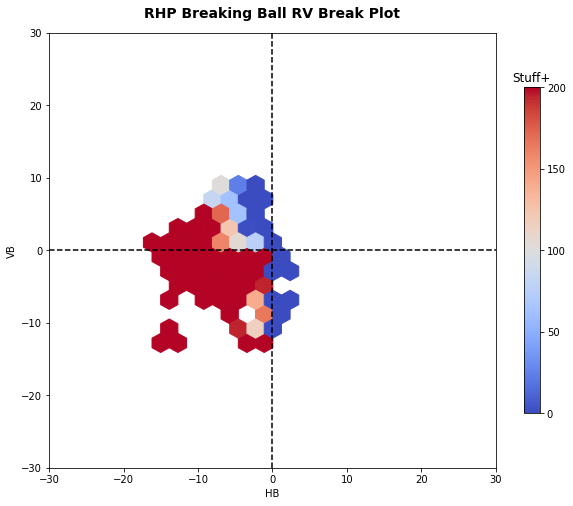

In [104]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb_tu['HorzBreak'], rhp_bb_tu['InducedVertBreak'], C = rhp_bb_tu['Stuff+'],cmap='coolwarm',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball RV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg Stuff+:', round(rhp_bb_tu['Stuff+'].mean(), 2))

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [105]:
print('Baseline LHP Breaking Ball RunValue Accuracy Score:', round(lhp_bb.rv.mean(), 2))

Baseline LHP Breaking Ball RunValue Accuracy Score: -0.02


In [106]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_bb_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.246
Test MAE: 0.127
Cross Val Score: [-0.00195888 -0.00023737 -0.00052625 -0.00149576  0.00109523]
Cross Val Score: -0.001 

R2 Score: 0.001
RMSE: 0.252
MAE: 0.129


- Average LHP Breaking Ball Run Value prediction error is .26 runs

In [107]:
lhp_bb_tu.dropna(inplace = True)

features_lhp_bb_tu = lhp_bb_tu.select_dtypes([np.number])
pred_lhp_bb_tu = lr.predict(features_lhp_bb_tu)
lhp_bb_tu['RV'] = pred_lhp_bb_tu

print(lhp_bb_tu.shape)
lhp_bb_tu.describe()

(58, 11)


,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,RV
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,73.034483,5.734483,2.837931,250.168966,-1.268966,5.508621,5.110345,0.003631
std,1.702583,3.253746,3.452527,40.296781,0.237832,0.257712,0.246868,0.005238
min,69.200000,-2.400000,-4.900000,145.700000,-1.700000,5.000000,4.800000,-0.009372
25%,72.000000,3.775000,0.300000,219.250000,-1.500000,5.300000,4.900000,-0.000368
50%,73.000000,6.150000,3.200000,258.200000,-1.300000,5.600000,5.050000,0.003676
75%,74.000000,7.675000,5.600000,281.425000,-1.100000,5.700000,5.300000,0.007341
max,77.100000,13.300000,10.800000,318.100000,-0.600000,5.900000,5.600000,0.015390


### LHP Breaking Ball RV Table

In [108]:
lhp_bb_tu['n_pitches'] = 1
lhp_bb_tu['xRV'] = pred_lhp_bb_tu
lhp_bb_tu['RV/100'] = round(((lhp_bb_tu['RV'] / (lhp_bb_tu['n_pitches'])) * 100), 2)
lhp_bb_tu['xRV/100'] = round(((lhp_bb_tu['xRV'] / (lhp_bb_tu['n_pitches'])) * 100), 2)
lhp_bb_tu['Stuff+'] = 100 * (-lhp_bb_tu['xRV/100'] / -lhp_bb_tu['xRV/100'].mean())


grouped_bb_l = lhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                                    as_index = False)['n_pitches', 'RV', 'xRV',].sum()

avg_bb_l = lhp_bb_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinAxis',
                                            'RelSide', 'RelHeight', 'Extension', 'Stuff+'].mean()
bb_l_rv_table = pd.merge(avg_bb_l, grouped_bb_l, how = 'left', on = ['Pitcher', 'PitcherThrows', 
                                                                     'TaggedPitchType'])

bb_l_rv_table['RV/100'] = round(((bb_l_rv_table['RV'] / (bb_l_rv_table['n_pitches'])) * 100), 2)
bb_l_rv_table['xRV/100'] = round(((bb_l_rv_table['xRV'] / (bb_l_rv_table['n_pitches'])) * 100), 2)

#Stuff+ = 100 * (predicted whiff% / league mean predicted whiff%)
#bb_r_rv_table['Stuff+'] = abs(100 * (bb_r_rv_table['xRV/100'] / bb_r_rv_table['xRV/100'].mean()))

bb_l_rv_table.insert(3, 'n_pitches', bb_l_rv_table.pop('n_pitches'))
bb_l_rv_table = bb_l_rv_table.round(1)
print(bb_l_rv_table.shape)
bb_l_rv_table.head(10)

(4, 16)


,Pitcher,PitcherThrows,TaggedPitchType,n_pitches,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,Stuff+,RV,xRV,RV/100,xRV/100
0,"Crosby, Alex",Left,Curveball,7,71.3,8.5,2.7,265.7,-1.2,5.6,4.9,85.8,0.0,0.0,0.3,0.3
1,"Crosby, Alex",Left,Slider,36,73.5,4.5,4.1,234.2,-1.3,5.4,5.1,160.2,0.2,0.2,0.6,0.6
2,"Martin, Scout",Left,Curveball,9,72.6,8.2,-0.2,282.8,-1.3,5.8,5.2,-65.5,-0.0,-0.0,-0.2,-0.2
3,"Martin, Scout",Left,Slider,6,72.7,6.5,0.3,278.9,-1.2,5.8,5.5,3.7,0.0,0.0,0.0,0.0


### LHP Breaking Ball xRV by HB & VB

LHP Breaking Ball Avgerage Stuff+: 100.0


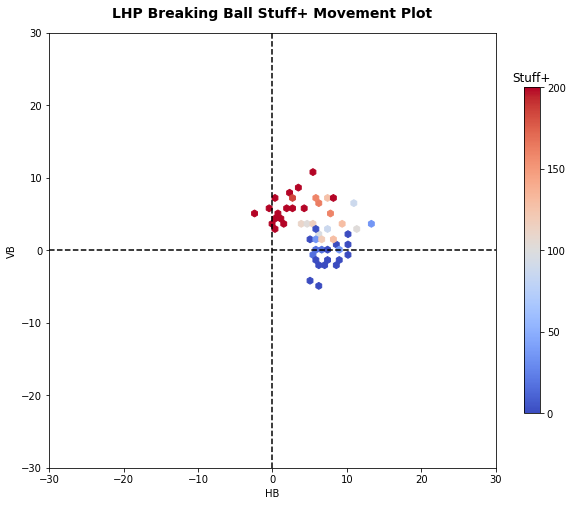

In [109]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb_tu['HorzBreak'], lhp_bb_tu['InducedVertBreak'], C = lhp_bb_tu['Stuff+'],cmap='coolwarm', 
           mincnt = 0, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avgerage Stuff+:', round(lhp_bb_tu['Stuff+'].mean(), 2))

## Off Speed RHP

#### Changeup, Splitter

In [110]:
print('Baseline RHP Off Speed RunValue Accuracy Score:', round(rhp_os.rv.mean(), 2))

Baseline RHP Off Speed RunValue Accuracy Score: -0.02


In [111]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_os_r = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.0
Test RMSE: 0.258
Test MAE: 0.137
Cross Val Score: [ 0.00066351 -0.00047375 -0.00125021  0.00069143  0.00037905]
Cross Val Score: 0.0 

R2 Score: 0.001
RMSE: 0.255
MAE: 0.136


- Average RHP Off Speed Run Value prediction error is .26 runs

In [112]:
rhp_os_tu.dropna(inplace = True)

features_rhp_os_tu = rhp_os_tu.select_dtypes([np.number])
pred_rhp_os_tu = lr.predict(features_rhp_os_tu)
rhp_os_tu['RV'] = pred_rhp_os_tu

print(rhp_os_tu.shape)
rhp_os_tu.describe()

(840, 11)


,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,RV
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,77.564405,10.636786,11.859643,218.860714,1.440238,5.869405,5.933214,0.000751
std,2.141749,7.365137,6.932386,50.241608,0.646066,0.419864,0.499563,0.010487
min,70.900000,-14.100000,-14.100000,1.300000,-0.100000,4.900000,4.600000,-0.058538
25%,76.100000,5.300000,8.400000,205.675000,0.900000,5.600000,5.500000,-0.003616
50%,77.500000,10.950000,13.300000,225.700000,1.600000,5.900000,6.000000,0.002265
75%,79.100000,16.925000,16.900000,238.700000,1.900000,6.200000,6.300000,0.007516
max,83.300000,26.500000,24.300000,356.700000,3.700000,6.600000,7.200000,0.022887


### RHP Off Speed RV Table

In [113]:
rhp_os_tu['n_pitches'] = 1
rhp_os_tu['xRV'] = pred_rhp_os_tu
rhp_os_tu['RV/100'] = round(((rhp_os_tu['RV'] / (rhp_os_tu['n_pitches'])) * 100), 2)
rhp_os_tu['xRV/100'] = round(((rhp_os_tu['xRV'] / (rhp_os_tu['n_pitches'])) * 100), 2)
rhp_os_tu['Stuff+'] = 100 * (-rhp_os_tu['xRV/100'] / -rhp_os_tu['xRV/100'].mean())


grouped_os_r = rhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                                    as_index = False)['n_pitches', 'RV', 'xRV',].sum()

avg_os_r = rhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinAxis',
                                            'RelSide', 'RelHeight', 'Extension', 'Stuff+'].mean()
os_r_rv_table = pd.merge(avg_os_r, grouped_os_r, how = 'left', on = ['Pitcher', 'PitcherThrows', 
                                                                     'TaggedPitchType'])

os_r_rv_table['RV/100'] = round(((os_r_rv_table['RV'] / (os_r_rv_table['n_pitches'])) * 100), 2)
os_r_rv_table['xRV/100'] = round(((os_r_rv_table['xRV'] / (os_r_rv_table['n_pitches'])) * 100), 2)

#Stuff+ = 100 * (predicted whiff% / league mean predicted whiff%)
#os_r_rv_table['Stuff+'] = abs(100 * (os_r_rv_table['xRV/100'] / os_r_rv_table['xRV/100'].mean()))

os_r_rv_table.insert(3, 'n_pitches', os_r_rv_table.pop('n_pitches'))
os_r_rv_table = os_r_rv_table.round(1)
print(os_r_rv_table.shape)
os_r_rv_table.head(10)

(17, 16)


,Pitcher,PitcherThrows,TaggedPitchType,n_pitches,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,Stuff+,RV,xRV,RV/100,xRV/100
0,"Absher, Luke",Right,ChangeUp,140,75.9,8.6,9.6,216.9,1.8,5.5,6.4,-68.2,-0.1,-0.1,-0.0,-0.0
1,"Absher, Luke",Right,Splitter,71,75.8,5.2,7.1,216.9,1.7,5.7,6.2,-780.7,-0.4,-0.4,-0.6,-0.6
2,"Bonilla, Sam",Right,ChangeUp,1,83.2,9.2,22.2,203.7,1.8,5.9,6.2,2055.9,0.0,0.0,1.6,1.6
3,"Fox Birdwell, Trejen",Right,ChangeUp,2,79.8,7.2,2.4,254.5,3.4,5.7,5.7,-1240.2,-0.0,-0.0,-0.9,-0.9
4,"Fox Birdwell, Trejen",Right,Splitter,39,79.4,6.6,2.2,259.7,3.0,5.8,5.7,-1530.4,-0.5,-0.5,-1.2,-1.2
5,"Nelson, Jonathan",Right,ChangeUp,87,77.2,15.9,8.6,238.2,0.9,5.1,6.1,76.2,0.1,0.1,0.1,0.1
6,"Ponder, Kohen",Right,ChangeUp,1,81.1,1.7,8.1,194.0,1.7,5.4,5.3,862.2,0.0,0.0,0.6,0.6
7,"Quinn, Billy",Right,ChangeUp,20,76.6,11.0,8.6,242.6,1.7,6.0,6.3,-1345.6,-0.2,-0.2,-1.0,-1.0
8,"Quinn, Billy",Right,Splitter,1,77.9,7.1,16.6,205.3,1.8,6.2,6.3,504.0,0.0,0.0,0.4,0.4
9,"Salyards, Brady",Right,ChangeUp,6,77.0,5.1,13.3,201.8,1.9,5.9,6.4,329.4,0.0,0.0,0.2,0.2


### RHP Off Speed xRV by HB & VB

RHP Off Speed Avg Stuff+: 100.0


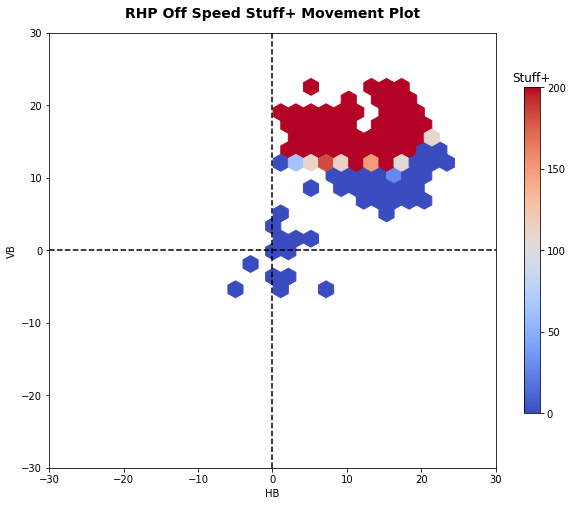

In [114]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os_tu['HorzBreak'], rhp_os_tu['InducedVertBreak'], C = rhp_os_tu['Stuff+'], cmap = 'coolwarm',
           mincnt = 2, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off Speed Avg Stuff+:', round(rhp_os_tu['Stuff+'].mean(), 2))

## Off Speed LHP
#### Changeup, Splitter

In [115]:
print('Baseline LHP Off Speed RunValue Accuracy Score:', round(lhp_os.rv.mean(), 2))

Baseline LHP Off Speed RunValue Accuracy Score: -0.01


In [116]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

lr = LinearRegression(n_jobs = -1).fit(X_train, y_train)

pred_os_l = lr.predict(X_test)
pred = lr.predict(X)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

print('Test R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3))
print('Cross Val Score:', cross_val_score(lr, X_test, y_test, cv = cv))
print('Cross Val Score:', round(cross_val_score(lr, X_test, y_test, cv = cv).mean(), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

Test R2 Score: 0.001
Test RMSE: 0.275
Test MAE: 0.142
Cross Val Score: [ 0.00014133 -0.00663688  0.00114874 -0.00495983  0.00133924]
Cross Val Score: -0.002 

R2 Score: 0.001
RMSE: 0.262
MAE: 0.138


- Average RHP Off Speed Run Value prediction error is .27 runs

In [117]:
lhp_os_tu.dropna(inplace = True)

features_lhp_os_tu = lhp_os_tu.select_dtypes([np.number])
pred_lhp_os_tu = lr.predict(features_lhp_os_tu)
lhp_os_tu['RV'] = pred_lhp_os_tu

print(lhp_os_tu.shape)
lhp_os_tu.describe()

(19, 11)


,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,RV
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,74.194737,-0.678947,9.805263,197.110526,-1.421053,5.473684,5.521053,0.009713
std,1.845557,6.512431,6.468855,46.065266,0.158391,0.144692,0.435353,0.009191
min,71.600000,-12.600000,0.800000,140.100000,-1.600000,5.300000,5.000000,-0.004821
25%,73.050000,-5.650000,4.650000,157.100000,-1.500000,5.300000,5.100000,0.001901
50%,73.600000,1.500000,9.500000,188.100000,-1.500000,5.500000,5.600000,0.007768
75%,75.150000,4.100000,15.400000,234.850000,-1.400000,5.600000,5.850000,0.017535
max,78.100000,10.900000,21.700000,276.100000,-1.000000,5.700000,6.400000,0.022813


### LHP Off Speed RV Table

In [118]:
lhp_os_tu['n_pitches'] = 1
lhp_os_tu['xRV'] = pred_lhp_os_tu
lhp_os_tu['RV/100'] = round(((lhp_os_tu['RV'] / (lhp_os_tu['n_pitches'])) * 100), 2)
lhp_os_tu['xRV/100'] = round(((lhp_os_tu['xRV'] / (lhp_os_tu['n_pitches'])) * 100), 2)
lhp_os_tu['Stuff+'] = 100 * (-lhp_os_tu['xRV/100'] / -lhp_os_tu['xRV/100'].mean())


grouped_os_l = lhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                                    as_index = False)['n_pitches', 'RV', 'xRV',].sum()

avg_os_l = lhp_os_tu.groupby(['Pitcher', 'PitcherThrows', 'TaggedPitchType'], 
                          as_index = False)['RelSpeed', 'HorzBreak', 'InducedVertBreak', 'SpinAxis',
                                            'RelSide', 'RelHeight', 'Extension', 'Stuff+'].mean()
os_l_rv_table = pd.merge(avg_os_l, grouped_os_l, how = 'left', on = ['Pitcher', 'PitcherThrows', 
                                                                     'TaggedPitchType'])

os_l_rv_table['RV/100'] = round(((os_l_rv_table['RV'] / (os_l_rv_table['n_pitches'])) * 100), 2)
os_l_rv_table['xRV/100'] = round(((os_l_rv_table['xRV'] / (os_l_rv_table['n_pitches'])) * 100), 2)

#Stuff+ = 100 * (predicted whiff% / league mean predicted whiff%)
#os_r_rv_table['Stuff+'] = abs(100 * (os_r_rv_table['xRV/100'] / os_r_rv_table['xRV/100'].mean()))

os_l_rv_table.insert(3, 'n_pitches', os_l_rv_table.pop('n_pitches'))
os_l_rv_table = os_l_rv_table.round(1)
print(os_l_rv_table.shape)
os_l_rv_table.head(10)

(2, 16)


,Pitcher,PitcherThrows,TaggedPitchType,n_pitches,RelSpeed,HorzBreak,InducedVertBreak,SpinAxis,RelSide,RelHeight,Extension,Stuff+,RV,xRV,RV/100,xRV/100
0,"Crosby, Alex",Left,ChangeUp,8,74.6,5.0,4.2,237.0,-1.4,5.3,5.1,191.2,0.1,0.1,1.9,1.9
1,"Martin, Scout",Left,ChangeUp,11,73.9,-4.8,13.9,168.1,-1.4,5.6,5.8,33.7,0.0,0.0,0.3,0.3


### LHP Off Speed xRV by HB & VB

LHP Off Speed Avg Stuff+: 100.0


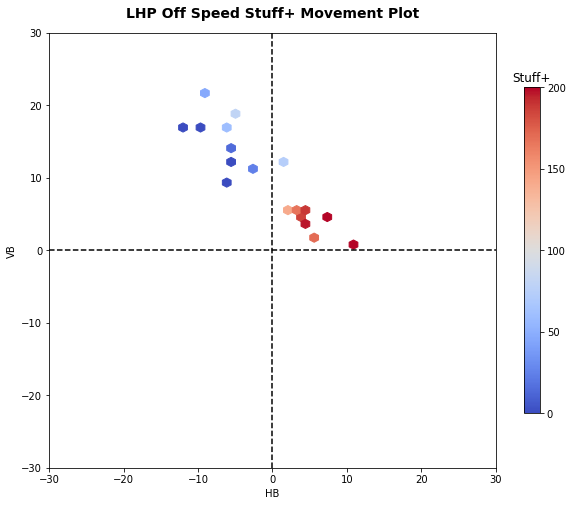

In [120]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os_tu['HorzBreak'], lhp_os_tu['InducedVertBreak'], C = lhp_os_tu['Stuff+'], cmap = 'coolwarm',
           mincnt = 0, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .75)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off Speed Avg Stuff+:', round(lhp_os_tu['Stuff+'].mean(), 2))